# Dynamic
Analyze a planar dual-rotor system to bring it to a specified state (e.g., a specific position).

$$
\ddot{x} = -(u_1 + u_2) \sin(\theta)
$$

$$
\ddot{y} = (u_1 + u_2) \cos(\theta) - mg
$$

$$
J\ddot{\theta} = \frac{1}{2}l(u_2 - u_1)
$$

This is a nonlinear system (**system dynamics** involve coupling between $u$ and $x$). The system can be linearized around the hovering state under the conditions:

$$
\theta = 0, \quad u_1 = u_2 = \frac{1}{2}mg,
$$

assuming the quadrotor operates near small angles, i.e., $\theta \approx 0$. Linearizing the system at hovering does not imply that the quadrotor remains in this state, but rather assumes that it operates close to the hovering state. The quadrotor can still have $\Delta u$ and $\Delta \theta$. The linearized model is fairly standard and can be discretized for LQR and MPC control.

---
# Convert to constrained QP 
Since the objective is no longer to return to the origin but to reach an arbitrary state $x_{ref}$, the total cost function $J$ over $H$ steps is:

$$
\min_{x_{1:H+1}, u_{1:H-1}} \sum_{k=1}^{H-1} \left[ \frac{1}{2}(x_k - x_{ref})^T Q_k (x_k - x_{ref}) + \frac{1}{2}u_k^T R_k u_k \right] + (x_H - x_{ref})^T Q_H(x_H - x_{ref})
$$

Expanding further:

$$
\min_{x_{1:H+1}, u_{1:H-1}} \sum_{k=1}^{H-1} \left[ \frac{1}{2} x_k^T Q_k x_k + \frac{1}{2} u_k^T R_k u_k - (Q_k x_{ref})^T x_k \right] + x_H^T P x_H - (Q_H x_{ref})^T x_H
$$

Subject to constraints:

$$
x_{min} \leq x \leq x_{max}, \quad u_{min} \leq u \leq u_{max}
$$

Where:
- $Q_{k}$, $R_{k}$, $Q_{H}$ are the weighting matrices for state cost, input cost, and final state cost, respectively.
- $x_{k}$ represents the system state.
- $u_{k}$ represents the system control input.
- $x_{ref}$ is the reference state.
- $H$ is the optimization time window length.

---

This can still be formulated as a standard Quadratic Programming (QP) problem (here $Q_k = Q$, $R_k = R$). As done in the previous section, decision variables are stacked together into $z$.

For solving the problem, OSQP is used with $N = 20$, since $dim(x) = 6$ and $dim(u) = 2$ (where $x_2$ to $x_{21}$ are decision variables, and $u$ spans from $u_1$ to $u_{20}$). Therefore, the total number of optimization variables is 160.

Since OSQP only supports inequality constraints $lower \leq Dz \leq upper$, all equality constraints are converted into inequality constraints with $lower = upper$.

---

The stacked variable is represented as:

$$
z = 
\begin{bmatrix}
u_1 \\
u_2 \\
x_2 \\
\vdots \\
x_{20} \\
u_{20} \\
x_{21}
\end{bmatrix} \in \mathbb{R}^{160}
$$



The quadratic cost matrix is given as:

$$
H =
\begin{bmatrix}
R & 0 & \cdots & 0 & 0 \\
0 & Q & \cdots & 0 & 0 \\
0 & 0 & Q & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & 0 \\
0 & 0 & 0 & 0 & P
\end{bmatrix}
\in \mathbb{R}^{160 \times 160}
$$



The constraint matrix is:

$$
D =
\begin{bmatrix}
B_1 & (-I) & \cdots & \cdots & 0 \\
0 & A & B & (-I) & \cdots & 0 \\
0 & 0 & \cdots & A_{20} & B_{20} & (-I) \\
- & - & - & - & - & - \\
& & S_u & & & \\
- & - & - & - & - & - \\
& & S_\theta & & & \\
\end{bmatrix}
\in \mathbb{R}^{(120+40+20) \times 160}
$$



The lower and upper bounds are:

$$
lower =
\begin{bmatrix}
-A_1 x_1 \\
0 \\
\vdots \\
0 \\
u_{min} \\
\vdots \\
\theta_{min}
\end{bmatrix}
\in \mathbb{R}^{(120+40+20)},
\quad
upper =
\begin{bmatrix}
-A_1 x_1 \\
0 \\
\vdots \\
0 \\
u_{max} \\
\vdots \\
\theta_{max}
\end{bmatrix}
\in \mathbb{R}^{(120+40+20)}
$$



The constraints include:
- 120 equality constraints for state dynamics ($x_{k+1} = A_k x_k + B u_k$, each providing $dim(x)$ constraints).
- 40 constraints on the input $u$ (there are 40 inputs, and $S_u \in \mathbb{R}^{40 \times 160}$ is the selection matrix such that $S_u z = u$).
- 20 constraints on the state $\theta$ (where $S_\theta \in \mathbb{R}^{20 \times 160}$ is the selection matrix such that $S_\theta z = \theta$).


In [1]:
import numpy as np
import scipy.linalg
import scipy.sparse as sparse
import osqp
from control import dare, lqr
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from functools import partial

from scipy.linalg import solve_discrete_are
from scipy.sparse import hstack, csr_matrix, eye,vstack

In [2]:
# Model parameters
g = 9.81  # m/s^2
m = 1.0  # kg
l = 0.3  # meters
J = 0.2 * m * l ** 2

# Thrust limits
umin = np.array([0.2 * m * g, 0.2 * m * g])
umax = np.array([0.6 * m * g, 0.6 * m * g])

h = 0.05  # time step (20 Hz)

In [3]:
def quad_dynamics(x, u):
    """
    Compute the state derivatives for the planar quadrotor.

    Parameters:
    x_sys : ndarray
        State vector [x_sys, y, theta, x_dot, y_dot, theta_dot].
    u : ndarray
        Control inputs [u1, u2].

    Returns:
    dxdt : ndarray
        State derivative vector.
    """
    theta = x[2]

    x_ddot = (1 / m) * (u[0] + u[1]) * np.sin(theta)
    y_ddot = (1 / m) * (u[0] + u[1]) * np.cos(theta) - g
    theta_ddot = (1 / J) * (l / 2) * (u[1] - u[0])

    dxdt = np.zeros(6)
    dxdt[0:3] = x[3:6]
    dxdt[3] = x_ddot
    dxdt[4] = y_ddot
    dxdt[5] = theta_ddot

    return dxdt


def quad_dynamics_rk4(x, u, h=h):
    """
    Perform Runge-Kutta 4 integration for the quadrotor dynamics.

    Parameters:
    x_sys : ndarray
        Current state vector.
    u : ndarray
        Control input.
    h : float
        Time step.

    Returns:
    x_next : ndarray
        Next state vector after time step h.
    """
    k1 = quad_dynamics(x, u)
    k2 = quad_dynamics(x + 0.5 * h * k1, u)
    k3 = quad_dynamics(x + 0.5 * h * k2, u)
    k4 = quad_dynamics(x + h * k3, u)

    x_next = x + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return x_next


def numerical_jacobian(func, x, epsilon=1e-6):
    """
    Compute the Jacobian matrix of a function numerically using finite differences.

    Parameters:
    func : callable
        Function for which to compute the Jacobian.
    x_sys : ndarray
        Point at which to compute the Jacobian.
    epsilon : float
        Perturbation size.

    Returns:
    jac : ndarray
        Jacobian matrix.
    """
    n = x.size
    fx = func(x)
    m = fx.size
    jac = np.zeros((m, n))
    for i in range(n):
        x_perturbed = np.copy(x)
        x_perturbed[i] += epsilon
        fx_perturbed = func(x_perturbed)
        jac[:, i] = (fx_perturbed - fx) / epsilon
    return jac


# Define functions for linearization
def dynamics_rk4_wrapper(x):
    return quad_dynamics_rk4(x, u_hover)


def dynamics_rk4_u_wrapper(u):
    return quad_dynamics_rk4(x_hover, u)

x_hover = np.zeros(6)
u_hover = np.array([0.5000000 * m * g, 0.5000000 * m * g])
# Compute A and B using numerical Jacobian
A = numerical_jacobian(dynamics_rk4_wrapper, x_hover)
B = numerical_jacobian(dynamics_rk4_u_wrapper, u_hover)

# Number of states and controls
Nx = 6  # number of states
Nu = 2  # number of control inputs

# Final time and number of time steps
Tfinal = 10.0
Nt = int(Tfinal / h) + 1
thist = np.arange(0, h * Nt, h)

# Cost weights
Q = np.eye(Nx)
R = 0.01 * np.eye(Nu)
Qn = np.eye(Nx)


def cost_function(xhist, uhist):
    """
    Compute the total cost over the history of states and controls.

    Parameters:
    xhist : ndarray
        History of states.
    uhist : ndarray
        History of control inputs.

    Returns:
    cost : float
        Total cost.
    """
    cost = 0.5 * xhist[:, -1].T @ Qn @ xhist[:, -1]
    for k in range(xhist.shape[1] - 1):
        cost += 0.5 * xhist[:, k].T @ Q @ xhist[:, k]
        cost += 0.5 * uhist[k].T @ R @ uhist[k]
    return cost


# Infinite LQR
$ K $ and $P$ are constant matrixs

In [4]:
# LQR Hover Controller
# Solve Discrete Algebraic Riccati Equation
P = solve_discrete_are(A, B, Q, R)
K = np.linalg.inv(R + B.T @ P @ B) @ (B.T @ P @ A)

def lqr_controller(x, xref,K=K):
    """
    LQR controller law.

    Parameters:
    t : float
        Current time (unused).
    x_sys : ndarray
        Current state.
    K : ndarray
        LQR gain matrix.
    xref : ndarray
        Reference state.

    Returns:
    u : ndarray
        Control input.
    """
    return u_hover - K @ (x - xref)

# Use Kronecker Product to Clearly Construct Large Matrices in QP
## **Definition of the Kronecker Product**

If we have two matrices:
$$
A =
\begin{bmatrix}
a_{11} & a_{12} \\
a_{21} & a_{22}
\end{bmatrix},
\quad
B =
\begin{bmatrix}
b_{11} & b_{12} \\
b_{21} & b_{22}
\end{bmatrix}
$$

The Kronecker product, denoted as $ A \otimes B $, is defined as:

$$
A \otimes B =
\begin{bmatrix}
a_{11}B & a_{12}B \\
a_{21}B & a_{22}B
\end{bmatrix}.
$$

This expands each entry in $ A $ into a block matrix, where each element $ a_{ij} $ in $ A $ is multiplied by the entire matrix $ B $.

For example:

If $ A = \begin{bmatrix} 1 & 2 \\ 3 & 4 \end{bmatrix} $ and $ B = \begin{bmatrix} 0 & 5 \\ 6 & 7 \end{bmatrix} $, then:

$$
A \otimes B =
\begin{bmatrix}
1 \cdot B & 2 \cdot B \\
3 \cdot B & 4 \cdot B
\end{bmatrix}
=
\begin{bmatrix}
0 & 5 & 0 & 10 \\
6 & 7 & 12 & 14 \\
0 & 15 & 0 & 20 \\
18 & 21 & 24 & 28
\end{bmatrix}.
$$

---

## **Sparse Kronecker Product**

In numerical computation, the Kronecker product can grow very large and is often sparse. Using `sparse.kron` in SciPy allows efficient computation and storage of the Kronecker product for sparse matrices.

---

## **Function Syntax**

```python
scipy.sparse.kron(A, B, format=None)

In [5]:
# Build QP matrices for OSQP
Nh = 20  # Horizon length (one second at 20Hz)

# Construct H matrix (quadratic cost)
#H = sparse.block_diag([Q] * Nh + [R] * Nh).tocsc()
H=sparse.block_diag([sparse.kron(sparse.eye(Nh-1),sparse.block_diag([R]*1+[Q]*1))]+[sparse.block_diag([R]*1+[P]*1)]  ).tocsc()
# Initialize b and other matrices
b = np.zeros(Nh * (Nx + Nu))

# Construct C matrix (dynamics constraints)
# First, state constraints
C_top = hstack((B,-eye(Nx),csr_matrix(np.zeros((Nx,(Nh-1)*(Nx+Nu))))))
# Then, the rest of the dynamics
C_rest1=csr_matrix(np.zeros((Nx*(Nh-1),Nu)))
C_rest2=hstack((sparse.kron(sparse.eye(Nh-1),np.hstack((A,B))),csr_matrix(np.zeros((Nx*(Nh-1),Nx)))))
C_rest3=hstack(  (csr_matrix(np.zeros((Nx*(Nh-1),Nx))),sparse.kron(sparse.eye(Nh-1), np.hstack((np.zeros((Nx,Nu)),-np.eye(Nx)  )  ))))
C = vstack((C_top,hstack((C_rest1,C_rest2+C_rest3))))


# Thrust constraints
U = sparse.kron(sparse.eye(Nh), np.hstack([np.eye(Nu), np.zeros((Nu, Nx))]))
Theta = sparse.kron(sparse.eye(Nh), np.array([[0, 0, 0, 0, 1, 0, 0, 0]]))

# Dynamics + thrust limit + theta constraints
D = vstack([
    C,
    U,
    Theta
]).tocsc()

# Define lower and upper bounds
lb = np.concatenate([
    np.zeros(Nx * Nh),  # Dynamics equality constraints
    np.tile(umin - u_hover, Nh),  # Control lower limits
    np.tile(-0.2, Nh)  # Theta lower limits
])

ub = np.concatenate([
    np.zeros(Nx * Nh),  # Dynamics equality constraints
    np.tile(umax - u_hover, Nh),  # Control upper limits
    np.tile(0.2, Nh)  # Theta upper limits
])

# Setup OSQP problem
prob = osqp.OSQP()
prob.setup(P=H, q=b, A=D, l=lb, u=ub, verbose=False, eps_abs=1e-8, eps_rel=1e-8, polish=True)

In [6]:
def mpc_controller(x, xref):
    """
    MPC controller using OSQP.

    Parameters:
    x_sys : ndarray
        Current state.
    K : ndarray
        LQR gain matrix.
    xref : ndarray
        Reference state.

    Returns:
    u : ndarray
        Control input.
    """
    lb[:6]=-A@x
    ub[:6] = -A @ x
    
    # the linear guys in function J due to the nonzero x_ref 
    for j in range(Nh-1):
        b[Nu+j*(Nx+Nu):Nu+j*(Nx+Nu)+Nx]=-Q@xref     
    b[Nu+(Nh-1)*(Nx+Nu):Nu+(Nh-1)*(Nx+Nu)+Nx]=-P@xref

    
    # Update the first Nx constraints to be the current state
    prob.update(q=b,l=lb, u=ub)

    # Update the QP's b vector based on the current state and reference
    # This is a placeholder as detailed implementation requires proper mapping
    # Here, we assume a simplified scenario

    # Solve QP
    results = prob.solve()


    # Extract the first control input
    delta_u = results.x_sys[:Nu]

    return u_hover + delta_u


def closed_loop(x0, controller, Nt, xref):
    """
    Simulate closed-loop system.

    Parameters:
    x0 : ndarray
        Initial state.
    controller : callable
        Controller function.
    Nt : int
        Number of time steps.
    xref : ndarray
        Reference state.

    Returns:
    xhist : ndarray
        History of states.
    uhist : ndarray
        History of control inputs.
    """
    xhist = np.zeros((Nx, Nt))
    uhist = np.zeros((Nu, Nt - 1))
    u0 = controller(x0, xref)
    xhist[:, 0] = x0
    uhist[:, 0] = u0
    for k in range(Nt - 1):
        u = controller(xhist[:, k], xref)
        # Enforce control limits
        u = np.clip(u, umin, umax)
        uhist[:, k] = u
        # Integrate dynamics
        x_next = quad_dynamics_rk4(xhist[:, k], u)
        xhist[:, k + 1] = x_next
    return xhist, uhist


# Define reference and initial states
x_ref = np.array([0.0, 1.0, 0.0, 0.0, 0.0, 0.0])
x0 = np.array([10.0, 2.0, 0.0, 0.0, 0.0, 0.0])

# Simulate closed-loop with LQR controller
xhist1, uhist1 = closed_loop(x0, lqr_controller, Nt, x_ref)

# Simulate closed-loop with MPC controller
xhist2, uhist2 = closed_loop(x0, mpc_controller, Nt, x_ref)



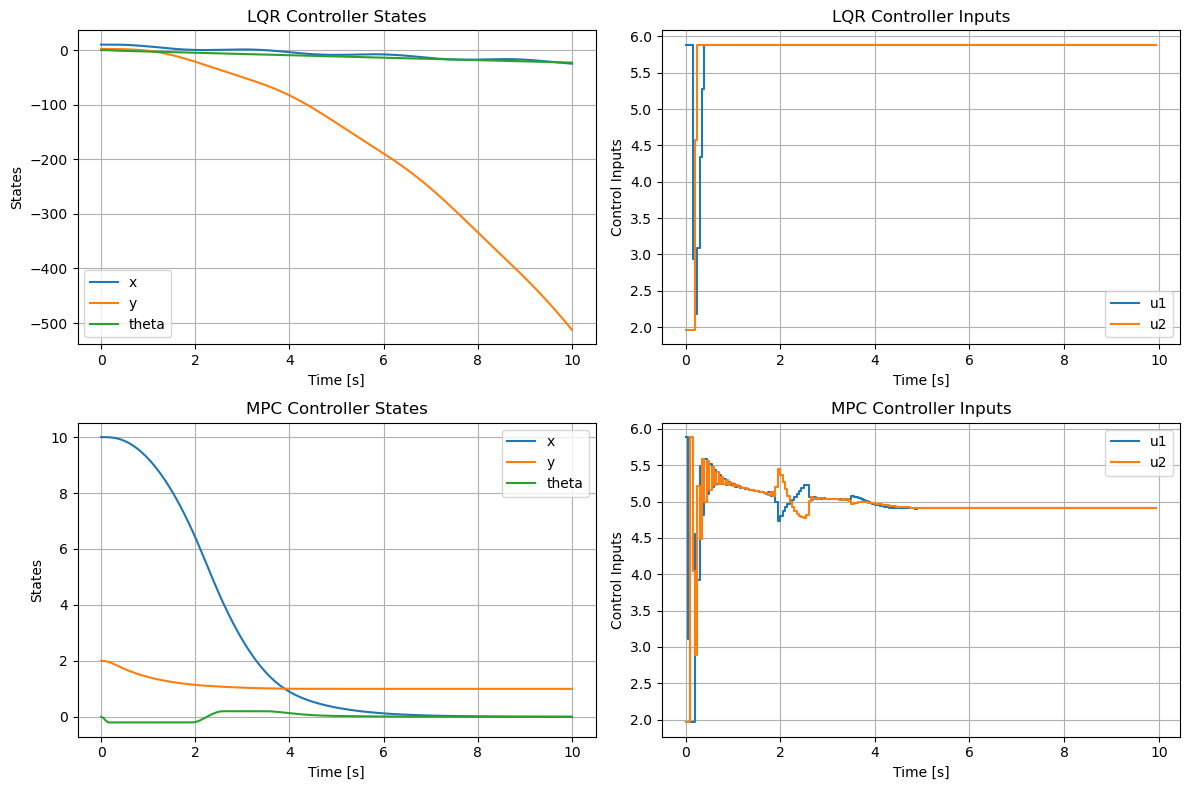

动画已保存为 quadrotor_lqr.gif
动画已保存为 quadrotor_mpc.gif


In [7]:
# Plotting States and Controls
import matplotlib.pyplot as plt

time = thist[:Nt]

plt.figure(figsize=(12, 8))

# Plot states for LQR
plt.subplot(2, 2, 1)
plt.plot(time, xhist1[0, :], label='x_sys')
plt.plot(time, xhist1[1, :], label='y')
plt.plot(time, xhist1[2, :], label='theta')
plt.title('LQR Controller States')
plt.xlabel('Time [s]')
plt.ylabel('States')
plt.legend()
plt.grid(True)

# Plot controls for LQR
plt.subplot(2, 2, 2)
plt.step(time[:-1], uhist1[0, :], where='post', label='u1')
plt.step(time[:-1], uhist1[1, :], where='post', label='u2')
plt.title('LQR Controller Inputs')
plt.xlabel('Time [s]')
plt.ylabel('Control Inputs')
plt.legend()
plt.grid(True)

# Plot states for MPC
plt.subplot(2, 2, 3)
plt.plot(time, xhist2[0, :], label='x_sys')
plt.plot(time, xhist2[1, :], label='y')
plt.plot(time, xhist2[2, :], label='theta')
plt.title('MPC Controller States')
plt.xlabel('Time [s]')
plt.ylabel('States')
plt.legend()
plt.grid(True)

# Plot controls for MPC
plt.subplot(2, 2, 4)
plt.step(time[:-1], uhist2[0, :], where='post', label='u1')
plt.step(time[:-1], uhist2[1, :], where='post', label='u2')
plt.title('MPC Controller Inputs')
plt.xlabel('Time [s]')
plt.ylabel('Control Inputs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# --------------- 动画生成部分开始 ---------------

def animate_quadrotor(xhist, uhist, title='Quadrotor Simulation', filename='quadrotor_animation.gif'):
    """
    生成3D动画并保存为GIF。

    Parameters:
    xhist : ndarray
        状态历史，形状为 (6, Nt)。
    uhist : ndarray
        控制输入历史，形状为 (2, Nt-1)。
    title : str
        动画标题。
    filename : str
        保存的GIF文件名。
    """
    # 设置四旋翼的几何形状（简化为一条长度为l的线段）
    quad_length = l  # 四旋翼臂长

    # 创建图形和3D轴
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(title)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Theta (rad)')
    ax.set_xlim(np.min(xhist[0, :]) - 1, np.max(xhist[0, :]) + 1)
    ax.set_ylim(np.min(xhist[1, :]) - 1, np.max(xhist[1, :]) + 1)
    ax.set_zlim(np.min(xhist[2, :]) - np.pi/4, np.max(xhist[2, :]) + np.pi/4)

    # 初始化四旋翼线段
    quad_line, = ax.plot([], [], [], 'o-', lw=2, color='blue')

    # 初始化轨迹线
    traj_line, = ax.plot([], [], [], '-', lw=1, color='gray', alpha=0.5)

    # 存储轨迹数据
    traj_x, traj_y, traj_theta = [], [], []

    def init():
        quad_line.set_data([], [])
        quad_line.set_3d_properties([])
        traj_line.set_data([], [])
        traj_line.set_3d_properties([])
        return quad_line, traj_line

    def update(frame):
        # 当前状态
        x, y, theta = xhist[0, frame], xhist[1, frame], xhist[2, frame]

        # 四旋翼的两端点
        x1 = x + (quad_length / 2) * np.cos(theta)
        y1 = y + (quad_length / 2) * np.sin(theta)
        theta_z = theta  # 在Z轴显示theta

        x2 = x - (quad_length / 2) * np.cos(theta)
        y2 = y - (quad_length / 2) * np.sin(theta)
        theta_z2 = theta  # 保持一致

        # 更新四旋翼线段
        quad_line.set_data([x1, x2], [y1, y2])
        quad_line.set_3d_properties([theta_z, theta_z2])

        # 更新轨迹
        traj_x.append(x)
        traj_y.append(y)
        traj_theta.append(theta)
        traj_line.set_data(traj_x, traj_y)
        traj_line.set_3d_properties(traj_theta)

        return quad_line, traj_line

    ani = FuncAnimation(fig, update, frames=range(0, xhist.shape[1], 2),
                        init_func=init, blit=True, interval=50)

    # 保存动画为GIF
    ani.save(filename, writer='pillow', fps=60)
    plt.close(fig)
    print(f"动画已保存为 {filename}")

# 生成LQR控制器的动画
animate_quadrotor(xhist1, uhist1, title='Quadrotor Simulation with LQR Controller', filename='quadrotor_lqr.gif')

# 生成MPC控制器的动画
animate_quadrotor(xhist2, uhist2, title='Quadrotor Simulation with MPC Controller', filename='quadrotor_mpc.gif')

# Results Analyze

Due to the large distance between the initial point and the target point, a simple LQR with clipped control inputs fails to achieve the control objective, whereas MPC remains effective.